In [1]:
import pandas as pd
import numpy as np


from itertools import  combinations_with_replacement


import matplotlib.pyplot as plt

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# Load the data

In [2]:
# bodyId for oviINr
oviINr_id = 423101189

In [3]:
import pandas as pd

# load the modularity data for the oviINr inputs
mod = pd.read_csv('modularity_runs/0.0/0-0_98765.txt',header=None, sep=' ')
mod.columns = ['id', '0.0']

In [4]:
# turn the id column into the index
mod.set_index('id', inplace=True)

In [5]:
# load the traced, non-cropped nodes from the hemibrain
HB_node_df = pd.read_csv("data/exported-traced-adjacencies-v1.2/traced-neurons.csv", index_col=0).fillna("None")
HB_node_df

,type,instance
bodyId,,
200326126,CL141,CL141_L
202916528,FS4C,FS4C(FQ12)_C4_R
203253072,FS4A,FS4A(AB)(FQ12)_C3_R
203253253,SMP505,SMP505(PDM22)_L
203257652,FS4C,FS4C(FQ12)_C6_R
...,...,...
7112579856,LC20,LC20
7112615127,AVLP335,AVLP335_R
7112617294,AVLP331,AVLP331_R


In [6]:
# must replace oviIN_nodes with the correct data.
valid_ovi_nodes = np.intersect1d(mod.index, HB_node_df.index)

# sort nodes by module id
valid_ovi_nodes = np.array(sorted(valid_ovi_nodes, key=lambda x: mod.loc[x, "0.0"]))

In [7]:
# load the traced, non-cropped edges from the hemibrain
HB_edge_df = pd.read_csv("data/exported-traced-adjacencies-v1.2/traced-total-connections.csv")  

In [34]:
# This cell takes ~ 15 seconds to work and takes up a lot of memory
HB_matrix = HB_edge_df.pivot_table(values="weight", index="bodyId_post", columns="bodyId_pre", fill_value=0.0)

# Correlation Coefficients of Inputs

For each neuron in oviIN's input connectome, we compute the synaptic weight of input connections to that neuron from the rest of the hemibrain network (excluding oviIN's input connectome).
We can then compute the correlation coefficient between these weights or the similarity (defined as, effectively, cosine of the angle between the vectors).

Below, we compute each of these values for every pair of neurons in oviIN's input connectome.

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


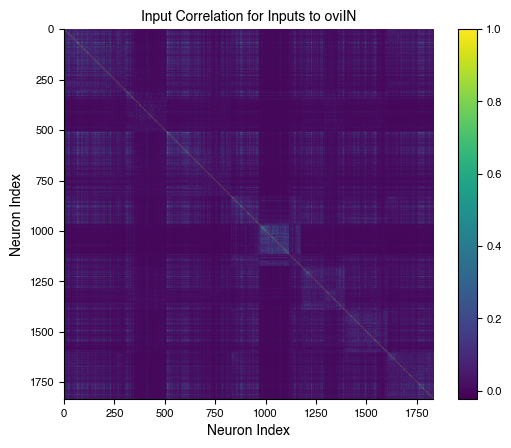

In [37]:
# gets the bodyId_post rows for the valid_ovi_nodes
X = HB_matrix.loc[valid_ovi_nodes, ~HB_matrix.columns.isin(valid_ovi_nodes)].values

# get the correlation matrix
C = np.corrcoef(X)
plt.imshow(C)
plt.title("Input Correlation for Inputs to oviIN")
plt.xlabel("Neuron Index")
plt.ylabel("Neuron Index")
plt.colorbar()
# plt.xticks(range(len(valid_ovi_nodes)), valid_ovi_nodes, rotation="vertical")
plt.savefig(f"figures/input_correlation/all_input_correlation.pdf", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


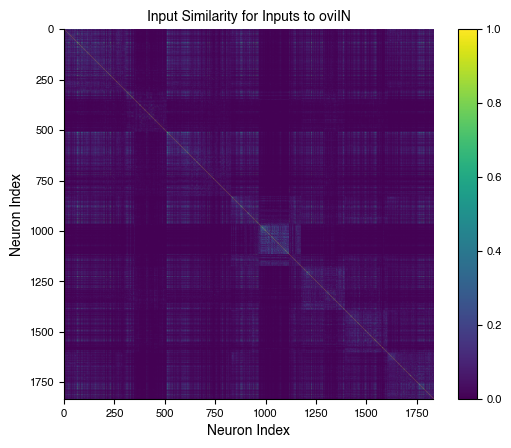

In [38]:
# get the similarity matrix
Xunit = X / np.sqrt(np.sum(X ** 2, axis=1))[:,None]
S = Xunit @ Xunit.T
plt.imshow(S)
plt.title("Input Similarity for Inputs to oviIN")
plt.xlabel("Neuron Index")
plt.ylabel("Neuron Index")
plt.colorbar()
plt.savefig(f"figures/input_correlation/all_input_similarity.pdf", bbox_inches="tight")

# Similarity within/between clusters

We pool these similarity meaures within and between clusters. We also compare to shuffled data, where cluster numbers are assigned randomly (keeping cluster sizes the same).

In [39]:
def corrDF_to_matrix(df, col1, col2, measure, stat):
    group_corrs = df.groupby([col1, col2]).agg({measure: stat})
    ngroups = df[col1].max()
    C = np.zeros((ngroups, ngroups))
    for i in range(ngroups):
        for j in range(i, ngroups):
            C[i,j] = C[j,i] = group_corrs.loc[(i+1, j+1), measure]
    return C

In [40]:
# shuffled data 
shuffled_df = mod.copy() #oviIN_nodes.loc[valid_ovi_nodes, ["0.0", "0.05", "0.1", "0.5", "0.75", "1.0", "instance", "celltype"]]
chis = ["0.0"]
n_trials = 200

for chi in chis:
    shuffles = np.zeros((len(shuffled_df), n_trials), dtype=int)
    for t in range(n_trials):
        shuffles[:, t] = shuffled_df[chi].values[np.random.permutation(len(shuffled_df))]
    tmp = pd.DataFrame(shuffles, index=shuffled_df.index, columns=[f"{chi}_s{t}" for t in range(n_trials)])
    shuffled_df = shuffled_df.merge(tmp, left_index=True, right_index=True)
shuffled_df

,0.0,0.0_s0,0.0_s1,0.0_s2,0.0_s3,0.0_s4,0.0_s5,0.0_s6,0.0_s7,0.0_s8,...,0.0_s190,0.0_s191,0.0_s192,0.0_s193,0.0_s194,0.0_s195,0.0_s196,0.0_s197,0.0_s198,0.0_s199
id,,,,,,,,,,,,,,,,,,,,,
1003215282,1,6,5,3,1,1,4,5,3,4,...,3,6,1,4,6,3,7,1,3,3
1005952640,2,1,3,3,4,6,1,1,2,3,...,4,4,3,4,6,2,7,5,1,1
1006928515,3,5,2,7,3,1,5,3,4,5,...,6,4,5,3,4,3,1,3,5,2
1007260806,3,4,1,1,1,5,6,7,4,4,...,5,3,7,4,4,3,1,5,7,4
1008024276,4,4,4,3,3,3,1,5,1,6,...,4,2,1,7,6,4,1,6,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987117151,2,5,5,3,6,6,7,7,1,7,...,4,4,5,2,3,2,2,5,2,6
987273073,6,5,7,3,5,1,7,1,4,3,...,5,7,7,6,4,4,1,5,4,4
988567837,5,4,1,5,1,6,4,6,2,4,...,2,1,6,1,1,3,2,4,1,5


In [41]:
corr_df = pd.DataFrame([[valid_ovi_nodes[i], valid_ovi_nodes[j], C[i,j], S[i,j]] for (i,j) in combinations_with_replacement(range(len(valid_ovi_nodes)), 2)],
                       columns=["bodyId1", "bodyId2", "correlation", "similarity"])

# corr_df = corr_df.merge(oviIN_nodes["0.0"], left_on="bodyId1", right_index=True)
# corr_df = corr_df.merge(oviIN_nodes["0.0"], left_on="bodyId2", right_index=True, suffixes=["_1","_2"])
corr_df = corr_df.merge(shuffled_df, left_on="bodyId1", right_index=True)
corr_df = corr_df.merge(shuffled_df, left_on="bodyId2", right_index=True, suffixes=["_1", "_2"])
corr_df

,bodyId1,bodyId2,correlation,similarity,0.0_1,0.0_s0_1,0.0_s1_1,0.0_s2_1,0.0_s3_1,0.0_s4_1,...,0.0_s190_2,0.0_s191_2,0.0_s192_2,0.0_s193_2,0.0_s194_2,0.0_s195_2,0.0_s196_2,0.0_s197_2,0.0_s198_2,0.0_s199_2
0,267551639,267551639,1.000000,1.000000,1,6,4,3,3,5,...,3,2,7,3,3,5,2,4,5,1
1,267551639,297563139,0.075209,0.077454,1,6,4,3,3,5,...,6,5,2,2,3,6,1,3,6,2
2,267551639,299290105,0.328147,0.330039,1,6,4,3,3,5,...,4,7,4,6,3,5,6,1,2,1
3,267551639,326253554,0.012971,0.019528,1,6,4,3,3,5,...,5,5,3,3,7,6,2,4,5,1
4,267551639,327587644,0.128136,0.131745,1,6,4,3,3,5,...,5,7,1,3,4,2,1,5,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679023,5901203505,5901221890,0.053695,0.057582,7,5,2,6,5,3,...,7,1,4,7,2,5,3,1,5,1
1679024,5901203505,6400000773,0.002578,0.005497,7,5,2,6,5,3,...,6,5,1,1,6,5,4,7,1,7
1679025,5901221890,5901221890,1.000000,1.000000,7,1,1,1,1,3,...,7,1,4,7,2,5,3,1,5,1
1679026,5901221890,6400000773,0.004619,0.007878,7,1,1,1,1,3,...,6,5,1,1,6,5,4,7,1,7


In [42]:
valid_corrs = corr_df[corr_df.bodyId1 != corr_df.bodyId2]

In the plot below, each square is colored according to the input similarity averaged over all pairs of distinct neurons from the corresponding clusters.

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


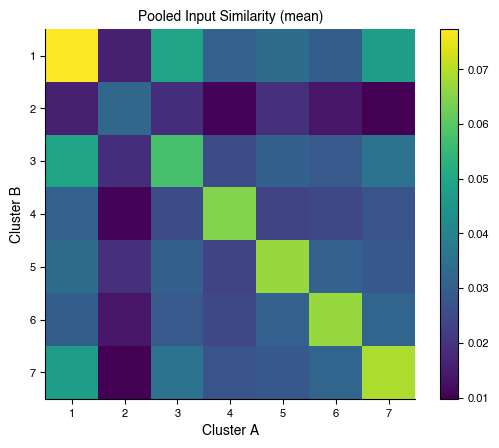

In [43]:
# pooled similarity
measure = "similarity"
stat = "mean"

n_clusters = mod['0.0'].max()
CC = np.zeros((n_clusters,n_clusters))
CC = corrDF_to_matrix(valid_corrs, "0.0_1", "0.0_2", measure, stat)

plt.imshow(CC)
plt.title(f"Pooled Input {measure.capitalize()} ({stat})")
plt.xticks(range(n_clusters), range(1,n_clusters+1))
plt.yticks(range(n_clusters), range(1,n_clusters+1))
plt.xlabel("Cluster A")
plt.ylabel("Cluster B")
plt.colorbar()
plt.savefig(f"figures/input_correlation/pooled_input_similarity.pdf", bbox_inches="tight")

In [44]:
# true_corrs = valid_corrs.groupby(["0.0_1", "0.0_2"]).agg({"correlation": ["median", "mean", "std"], "similarity": ["median", "mean", "std"]})
cluster_corrs = valid_corrs.groupby(["0.0_1", "0.0_2"]).agg({"correlation": ["median", "mean", "std"], "similarity": ["median", "mean", "std"]})
cluster_corrs

correlation                     similarity                    
                 median      mean       std     median      mean       std
0.0_1 0.0_2                                                               
1     1        0.029454  0.075550  0.120809   0.031475  0.077363  0.120460
      2       -0.000725  0.013820  0.051544   0.000625  0.015645  0.051435
      3        0.011990  0.047246  0.089482   0.014338  0.049336  0.089171
      4        0.000414  0.028634  0.080990   0.003028  0.031119  0.080601
      5        0.004949  0.031691  0.077833   0.007102  0.033670  0.077576
      6        0.001496  0.027629  0.075363   0.003771  0.029809  0.075046
      7        0.010296  0.045527  0.091647   0.012603  0.047618  0.091288
2     2        0.003574  0.030523  0.080534   0.005360  0.032216  0.080416
      3        0.000030  0.016546  0.050251   0.002013  0.018583  0.050150
      4       -0.001605  0.007982  0.043397   0.000093  0.010375  0.043257
      5        0.000489  0.016918  0.048584   0.002375  0.018813  0.048498
      6       -0.000885  0.011905  0.047715   0.000547  0.013997  0.047558
      7       -0.001251  0.007735  0.042200   0.000000  0.009790  0.042054
3     3        0.018436  0.055378  0.093876   0.021023  0.057694  0.093560
      4       -0.001140  0.022395  0.069012   0.001602  0.025194  0.068634
      5        0.004389  0.028227  0.067291   0.006755  0.030447  0.067043
      6        0.001544  0.026269  0.067611   0.004007  0.028709  0.067311
      7        0.002342  0.033167  0.077168   0.005001  0.035537  0.076831
4     4        0.013721  0.061849  0.110727   0.016935  0.064930  0.110502
      5        0.000236  0.021108  0.064357   0.002859  0.023709  0.064096
      6       -0.000046  0.021639  0.063969   0.002696  0.024493  0.063629
      7       -0.000703  0.024481  0.071395   0.002113  0.027264  0.071015
5     5        0.030528  0.065081  0.098863   0.032682  0.067060  0.098612
      6        0.005742  0.028907  0.067025   0.008160  0.031168  0.066786
      7        0.002241  0.026114  0.069974   0.004627  0.028335  0.069692
6     6        0.028129  0.064494  0.100386   0.030556  0.066854  0.100148
      7        0.003404  0.029544  0.071000   0.005972  0.031960  0.070776
7     7        0.027872  0.066894  0.104960   0.030505  0.069156  0.104630

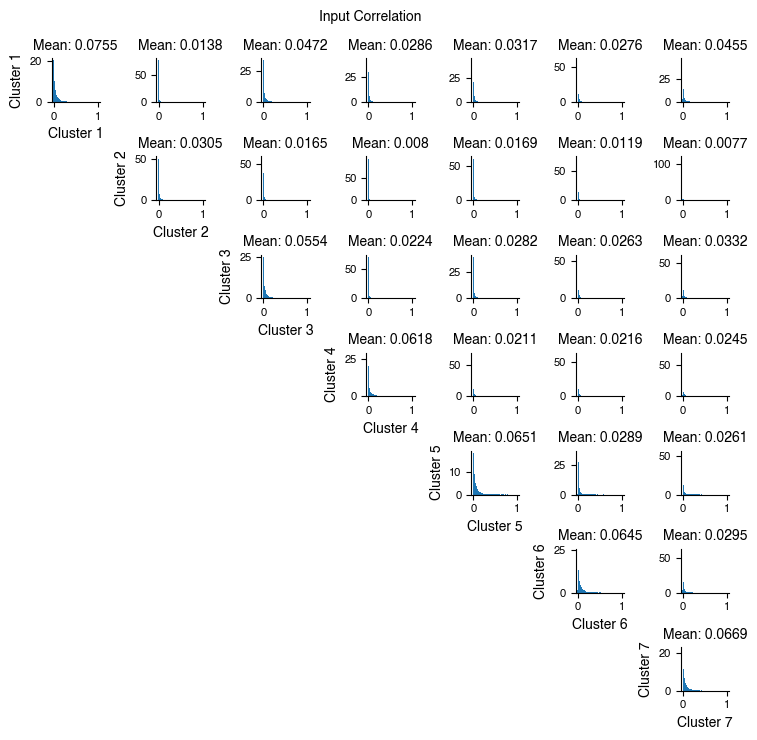

In [45]:
eps = 0.05
measure = "correlation"
stat = "mean"
plt.figure(tight_layout="tight",
           figsize=(7.5, 7.5))
plt.suptitle(f"Input {measure.capitalize()}")
for i in range(n_clusters):
    for j in range(i,n_clusters):
        plt.subplot(n_clusters,n_clusters,i*n_clusters + j + 1)
        plt.hist(valid_corrs[(valid_corrs["0.0_1"] == (i+1)) & (valid_corrs["0.0_2"] == (j+1))][measure],
                 bins=100, density=True)
        # plt.axvline(cluster_corrs.loc[(i+1, j+1), (measure, stat)], color="red")
        plt.xlim(-eps, 1 + eps)
        plt.title(f"{stat.capitalize()}: {round(cluster_corrs.loc[(i+1, j+1), (measure, stat)], 4)}")
        if j == i:
            plt.xlabel(f"Cluster {i+1}")
            plt.ylabel(f"Cluster {j+1}")

#plt.savefig(f"figures/input_correlation/oviIN_input_connectome_input_{measure}.pdf", bbox_inches="tight")

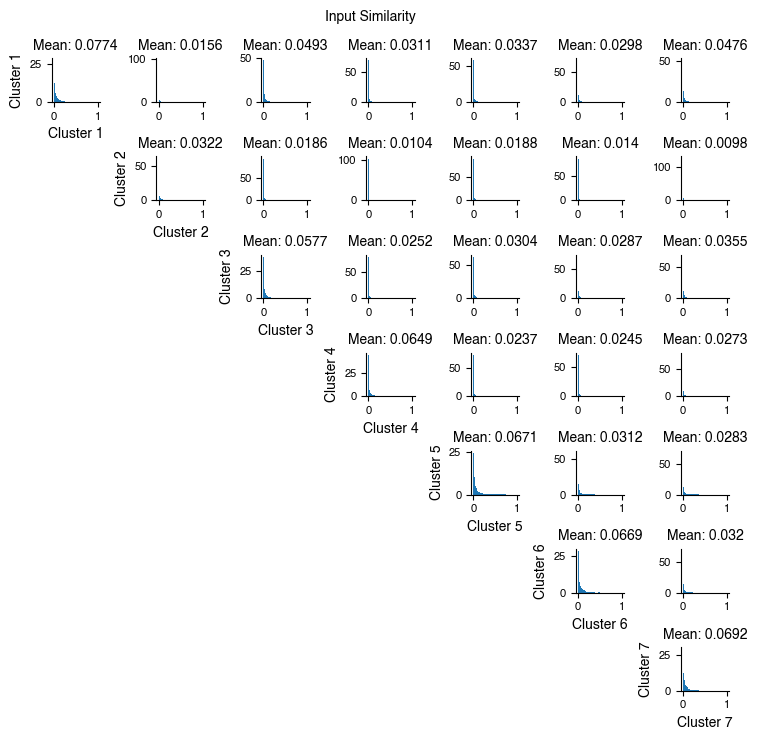

In [46]:
eps = 0.05
measure = "similarity"
stat = "mean"
plt.figure(tight_layout="tight",
           figsize=(7.5, 7.5))
plt.suptitle(f"Input {measure.capitalize()}")
for i in range(n_clusters):
    for j in range(i,n_clusters):
        plt.subplot(n_clusters,n_clusters,i*n_clusters + j + 1)
        plt.hist(valid_corrs[(valid_corrs["0.0_1"] == (i+1)) & (valid_corrs["0.0_2"] == (j+1))][measure],
                 bins=100, density=True)
        # plt.axvline(cluster_corrs.loc[(i+1, j+1), (measure, stat)], color="red")
        plt.xlim(-eps, 1 + eps)
        plt.title(f"{stat.capitalize()}: {round(cluster_corrs.loc[(i+1, j+1), (measure, stat)], 4)}")
        if j == i:
            plt.xlabel(f"Cluster {i+1}")
            plt.ylabel(f"Cluster {j+1}")

#plt.savefig(f"figures/input_correlation/oviIN_input_connectome_input_{measure}.pdf", bbox_inches="tight")

In [48]:
lots_of_C = np.zeros((n_trials, n_clusters, n_clusters))
for t in range(n_trials):
    lots_of_C[t, :, :] = corrDF_to_matrix(valid_corrs, f"0.0_s{t}_1", f"0.0_s{t}_2", measure, stat)

The plot below gives a little more detail, showing the distribution of averages over the shuffles.

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


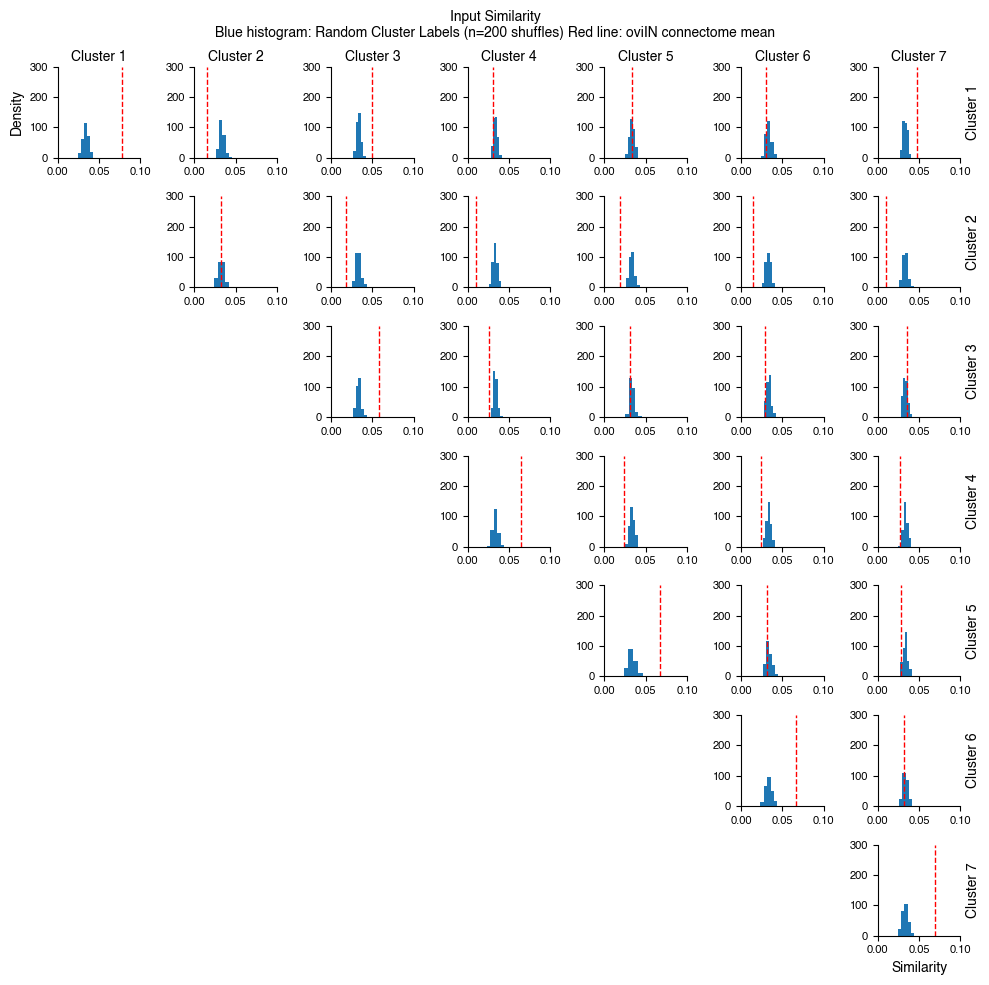

In [50]:
eps = 0.05
measure = "similarity"
stat = "mean"

lots_of_C = np.zeros((n_trials, n_clusters, n_clusters))
for t in range(n_trials):
    lots_of_C[t, :, :] = corrDF_to_matrix(valid_corrs, f"0.0_s{t}_1", f"0.0_s{t}_2", measure, stat)

plt.figure(tight_layout="tight",
           figsize=(10,10))
plt.suptitle(f"Input {measure.capitalize()}\nBlue histogram: Random Cluster Labels (n={n_trials} shuffles)\tRed line: oviIN connectome {stat}")
for i in range(n_clusters):
    for j in range(i,n_clusters):
        plt.subplot(n_clusters,n_clusters,i*n_clusters + j + 1)
        plt.axvline(CC[i, j], color="red", linewidth=1, linestyle="dashed")
        #plt.hist(lots_of_C[:, i, j], bins=10, density=True)
        plt.hist(lots_of_C[:, i, j], bins=5, density=True)
        #plt.hist(lots_of_C[:, i, j], density=True)
        # set the x-axis limits
        plt.xlim(0, 0.1)
        # set the y-axis limits
        plt.ylim(0, 300)
        if i == 0:
            plt.gca().xaxis.set_label_position("top")
            plt.xlabel(f"Cluster {j+1}")
            # plt.title(f"Cluster {j+1}")
            if j == 0:
                plt.ylabel("Density")
        if j == n_clusters - 1:
            plt.gca().yaxis.set_label_position("right")
            plt.ylabel(f"Cluster {i+1}")
            if i == n_clusters - 1:
                plt.xlabel(measure.capitalize())

plt.savefig(f"figures/input_correlation/comparison_to_shuffle_{measure}.pdf")

And below, we compute the z-score of the red lines in the above plot, to condense the plot a little and make the point (the diagonal is mostly positive; off-diagonal is mostly negative) more clearly.

In [63]:
Z = np.zeros_like(CC)
zmin, zmax = 0.0, 0.0
shuffle_C_mean = lots_of_C.mean(axis=0)
shuffle_C_std = lots_of_C.std(axis=0)
Z = (CC - shuffle_C_mean) / shuffle_C_std

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


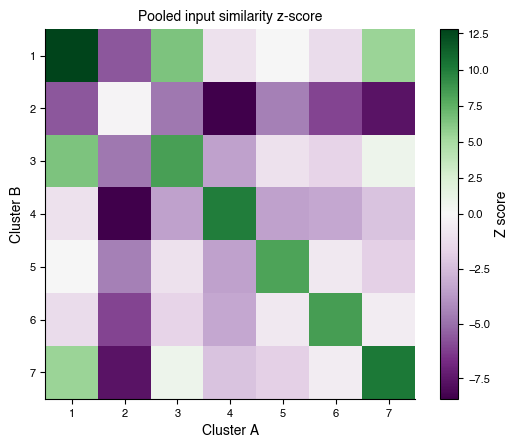

In [ ]:
from matplotlib import colors

plt.imshow(Z, cmap="PRGn", norm=colors.TwoSlopeNorm(vcenter=0.0, vmin=Z.min(), vmax=Z.max()))
# plt.title(f"Pooled input {measure} z-score")
plt.xticks(range(n_clusters), range(1,n_clusters+1))
plt.yticks(range(n_clusters), range(1,n_clusters+1))
plt.xlabel("Cluster A")
plt.ylabel("Cluster B")
plt.colorbar(label="Z score")
plt.savefig(f"figures/input_correlation/shuffle_z_score_{measure}.pdf")